In [ ]:
!pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install tqdm
!pip3 install transformers

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.10.2+cu113 (from versions: 1.11.0, 1.11.0+cu113, 1.12.0, 1.12.0+cu113, 1.12.1, 1.12.1+cu113, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1)
ERROR: No matching distribution found for torch==1.10.2+cu113
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
import pandas as pd
df_train = pd.read_csv("/content/New_Train.csv")

In [ ]:
df_val = pd.read_csv("/content/New_dev.csv")

In [ ]:
df_test = pd.read_csv("/content/New_Test.csv")

In [ ]:
df_train['text'] = df_train['Headline'] + ' ' + df_train['articleBody']

In [ ]:
df_val['text'] = df_val['Headline'] + ' ' + df_val['articleBody']

In [ ]:
df_test['text'] = df_test['Headline'] + ' ' + df_test['articleBody']

In [ ]:
df_train.head()

,Body ID,articleBody,Headline,Stance,text
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",0,"You Can Be Fined $1,500 If Your Passenger Is U..."
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,2,Missouri lawmakers condemn Las Vegas shooting ...
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,2,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,0,Obama’s Daughters Caught on Camera Burning US ...
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,0,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = df_train['Stance'].astype(int).values
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df_train['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 439/439 [00:39<00:00, 11.10it/s]


Epochs: 1 | Train Loss:  0.818             | Train Accuracy:  0.454             | Val Loss:  1.194             | Val Accuracy:  1.497


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()


    # Tracking variables
    predictions_labels = []
    true_labels = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.890


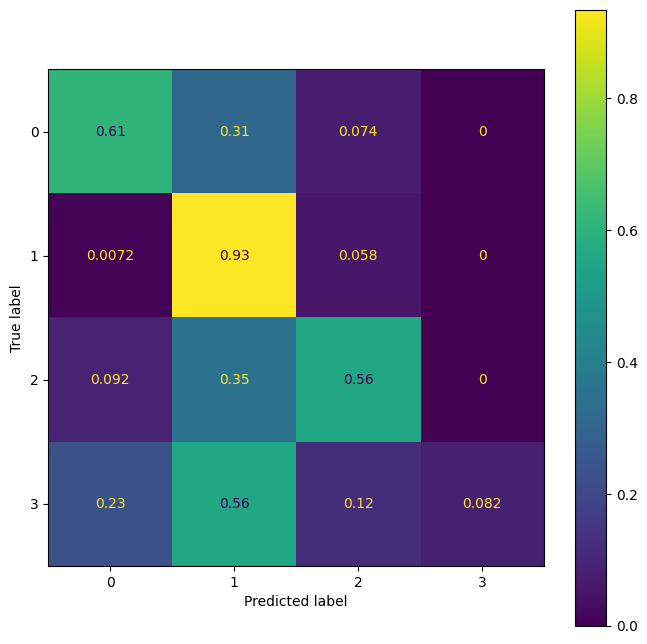

In [ ]:
# Plot confusion matrix.
labels = [0, 1, 2, 3]
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)

plt.show()

In [ ]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_true=true_labels, y_pred=pred_labels, labels=labels)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.61      0.72       460
           1       0.33      0.93      0.49       138
           2       0.69      0.56      0.62       207
           3       1.00      0.08      0.15        73

    accuracy                           0.61       878
   macro avg       0.73      0.55      0.50       878
weighted avg       0.76      0.61      0.62       878



In [ ]:
torch.save(model.state_dict(), "gpt2-text-classifier-model.pt")

In [ ]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("/content/gpt2-text-classifier-model.pt"))
model_new.eval()


SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=98304, out_features=5, bias=True)
)

In [ ]:
example_text = """
The UK has accused President Putin of plotting to install a pro-Moscow figure to lead Ukraine's government.

The Foreign Office took the unusual step of naming former Ukrainian MP Yevhen Murayev as a potential Kremlin candidate.

Russia has moved 100,000 troops near to its border with Ukraine but denies it is planning an invasion.

UK ministers have warned that the Russian government will face serious consequences if there is an incursion.

In a statement, Foreign Secretary Liz Truss said: "The information being released today shines a light on the extent of Russian activity designed to subvert Ukraine, and is an insight into Kremlin thinking.

"Russia must de-escalate, end its campaigns of aggression and disinformation, and pursue a path of diplomacy."

The Russian Ministry of Foreign Affairs tweeted that the Foreign Office was "circulating disinformation" and urged it to "cease these provocative activities" and "stop spreading nonsense".

"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

the uk has accused president putin of plotting to install a pro-moscow figure to lead ukraine's government. the foreign office took the unusual step of naming former ukrainian mp yevhen murayev as a potential kremlin candidate. russia has moved 100,000 troops near to its border with ukraine but denies it is planning an invasion. uk ministers have warned that the russian government will face serious consequences if there is an incursion. in a statement, foreign secretary liz truss said: "the information being released today shines a light on the extent of russian activity designed to subvert ukraine, and is an insight into kremlin thinking. "russia must de-escalate, end its campaigns of aggression and disinformation, and pursue a path of diplomacy." the russian ministry of foreign affairs tweeted that the foreign office was "circulating disinformation" and urged it to "cease these provocative activities" and "stop spreading nonsense".


In [ ]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [ ]:
print(output)

tensor([[ -0.5366,   0.4003,  -0.0825,  -3.3320, -10.7104]],
       grad_fn=<AddmmBackward0>)


In [ ]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [ ]:
print(prob)

tensor([1.9275e-01, 4.9192e-01, 3.0355e-01, 1.1776e-02, 7.3551e-06],
       grad_fn=<SelectBackward0>)


In [ ]:
pred_label = output.argmax(dim=1).item()
print(pred_label)

1


In [ ]:
example_text = """
None of the books on Pink’s 13-title list has been banned statewide. Ten have been temporarily or permanently removed or restricted from shelves in at least one Florida school district, according to reports we reviewed from the Florida Department of Education, Collier County school district and PEN America. We don’t see any records of Florida schools removing three of the titles Pink listed.

Seven of these books were removed from schools in four districts, by state and Collier County counts. By PEN America’s most liberal definition of a "ban," 10 books Pink named were restricted or removed temporarily or permanently from schools in 17 of the state’s 67 school districts.

Pink later clarified on X that some of the books she had mentioned were banned in one or more Florida school districts.
"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

none of the books on pink’s 13-title list has been banned statewide. ten have been temporarily or permanently removed or restricted from shelves in at least one florida school district, according to reports we reviewed from the florida department of education, collier county school district and pen america. we don’t see any records of florida schools removing three of the titles pink listed. seven of these books were removed from schools in four districts, by state and collier county counts. by pen america’s most liberal definition of a "ban," 10 books pink named were restricted or removed temporarily or permanently from schools in 17 of the state’s 67 school districts. pink later clarified on x that some of the books she had mentioned were banned in one or more florida school districts.


In [ ]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [ ]:
print(output)

tensor([[ -0.4147,   0.7670,  -1.0225,  -3.2996, -10.9998]],
       grad_fn=<AddmmBackward0>)


In [ ]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [ ]:
print(prob)

tensor([2.0574e-01, 6.7072e-01, 1.1204e-01, 1.1493e-02, 5.2032e-06],
       grad_fn=<SelectBackward0>)


In [ ]:
pred_label = output.argmax(dim=1).item()
print(pred_label)

1


In [ ]:
example_text = """
The statement squares with a comparison of Thanksgiving dinner costs and wages. Since the American Farm Bureau Federation began calculating the typical price of a Thanksgiving dinner in 1986, only three other years have had Thanksgiving dinner costs represent a smaller percentage of median weekly income.

Jean-Pierre made a few errors in how she described the data, notably that the data goes back only to 1986.
"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

the statement squares with a comparison of thanksgiving dinner costs and wages. since the american farm bureau federation began calculating the typical price of a thanksgiving dinner in 1986, only three other years have had thanksgiving dinner costs represent a smaller percentage of median weekly income. jean-pierre made a few errors in how she described the data, notably that the data goes back only to 1986.


In [ ]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [ ]:
print(output)

tensor([[ 0.7099, -0.4287,  0.1970, -2.9626, -6.5984]],
       grad_fn=<AddmmBackward0>)


In [ ]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [ ]:
print(prob)

tensor([5.1411e-01, 1.6465e-01, 3.0783e-01, 1.3065e-02, 3.4444e-04],
       grad_fn=<SelectBackward0>)


In [ ]:
pred_label = output.argmax(dim=1).item()
print(pred_label)

0
